In [283]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

###### Drill: tf-idf scores

![](https://dha4w82d62smt.cloudfront.net/items/0W2b0K0r0O3N2i2S3j1A/Screen%20Shot%202018-02-01%20at%208.43.57%20AM.png?X-CloudApp-Visitor-Id=c85d38c5e1fd13bc387f4676e2ffc628&v=1e3fbf95)

![](https://dha4w82d62smt.cloudfront.net/items/131o3A3g0s2U3l2w1E1t/Screen%20Shot%202018-02-01%20at%208.44.58%20AM.png?X-CloudApp-Visitor-Id=c85d38c5e1fd13bc387f4676e2ffc628&v=2cb723be)

![](https://dha4w82d62smt.cloudfront.net/items/1p0l18041P053Y43150c/Screen%20Shot%202018-02-01%20at%208.46.00%20AM.png?X-CloudApp-Visitor-Id=c85d38c5e1fd13bc387f4676e2ffc628&v=6aa84d3d)

```
Monty        1.585 | 0    | 0
Python           1 | 0    | 0
sketch           0 | 0    | 0
laugh            1 | 0    | 0
funny        1.585 | 0    | 0
best             0 | .585 | 0 
ice cream        0 | 1    | 1
dessert          0 | 1.58 | 0
taste            0 | 1    | 2
```

 Let's talk about this

"Each document will get a score for each topic, with higher scores indicating that the document is relevant to the topic. Documents can pertain to more than one topic."

In [284]:
from nltk.corpus import gutenberg
import re
from sklearn.model_selection import train_test_split

#reading in the data, this time in the form of paragraphs
emma=gutenberg.paras('austen-emma.txt')
#processing
emma_paras=[]
for paragraph in emma:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    emma_paras.append(' '.join(para))

print(emma_paras[0:4])

['[ Emma by Jane Austen 1816 ]', 'VOLUME I', 'CHAPTER I', 'Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to distress or vex her .']


In [285]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test = train_test_split(emma_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True, #we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
emma_paras_tfidf=vectorizer.fit_transform(emma_paras)
print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
# Question: What is CSR? NOT NEEDED!
X_train_tfidf_csr = X_train_tfidf

#number of paragraphs
# Question: Let's walk through the code below
n = X_train_tfidf_csr.shape[0]
#A empty list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
# nonzero() returns 2 arrays. That's your X and Y of where the data is stored!
# zip combines two arrays
# 1a, 2b, 3c
# using "*X_train_tfidf_csr" combines the two arrays
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 1948
Original sentence: A very few minutes more , however , completed the present trial .
Tf_idf vector: {'present': 0.70142321085794701, 'minutes': 0.71274503103825837}


In [286]:
# for i in X_train_tfidf.toarray():
#     print(i)
#     z = zip(i, vectorizer.get_feature_names())
#     for j in z:
#         print(j)
#     break

X_train_tfidf.shape

(1422, 1948)

Question: What does this mean?

> Okay, now we have our vectors, with one vector per paragraph. It's time to do some dimension reduction. We use the Singular Value Decomposition (SVD) function from sklearn rather than PCA because we don't want to mean-center our variables (and thus lose sparsity):

In [287]:
# 1618, 1942, 1203
# svd.components_[0].argsort()
# vectorizer.get_feature_names()[1203]

a = [1,2,3,4,5]
top_components = a[-3:]
top_components

[3, 4, 5]

In [288]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
# Question: Why do we use x_train_lsa AND x_train as an index?
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    top_components = svd.components_[i].argsort()[-5:]
    print(len(svd.components_[0]))
    for t in top_components:
        print("Ze component is: ", vectorizer.get_feature_names()[t])
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 45.1899473582
Component 0:
1948
Ze component is:  papa
Ze component is:  just
Ze component is:  sorry
Ze component is:  yes
Ze component is:  oh
" Oh !    0.999292
" Oh !    0.999292
" Oh !    0.999292
" Oh !    0.999292
" Oh !    0.999292
" Oh !    0.999292
" Oh !    0.999292
" Oh !    0.999292
" Oh !    0.999292
" Oh !    0.999292
Name: 0, dtype: float64
Component 1:
1948
Ze component is:  miss
Ze component is:  mrs
Ze component is:  said
Ze component is:  mr
Ze component is:  emma
" You have made her too tall , Emma ," said Mr . Knightley .                                                                                                                0.634985
" You get upon delicate subjects , Emma ," said Mrs . Weston smiling ; " remember that I am here . Mr .                                                                     0.578978
" I do not know what your opinion may be , Mrs . Weston ," said Mr . Knightley , " of this great intimac

In [289]:
from sklearn.metrics.pairwise import cosine_similarity

# cos = cosine_similarity(X_train_tfidf, X_train_tfidf)

In [290]:
sent = vectorizer.transform(["hot and tired"])
love = cosine_similarity(sent, X_train_tfidf)
top_matches = love.argsort()[0][-10:]
for i in top_matches:
    print("=====")
    print(X_train[i])

=====
" Very true ," he gravely replied ; " it was very bad ."
=====
" He is very plain , undoubtedly  remarkably plain : but that is nothing compared with his entire want of gentility .
=====
" And do you really believe the affair to have been carrying on with such perfect secresy ? The Campbells , the Dixons , did none of them know of the engagement ?"
=====
" It appears to me the most desirable arrangement in the world ."
=====
" I have no doubt of his being a very respectable young man .
=====
" Oh !
=====
It was hot ; and after walking some time over the gardens in a scattered , dispersed way , scarcely any three together , they insensibly followed one another to the delicious shade of a broad short avenue of limes , which stretching beyond the garden at an equal distance from the river , seemed the finish of the pleasure grounds . It led to nothing ; nothing but a view at the end over a low stone wall with high pillars , which seemed intended , in their erection , to give the app

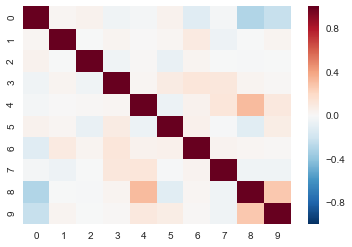

Key:
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being

In [291]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])


In [296]:
# Drill 0: Apply LSA to test set

svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
lsa = lsa.fit(X_train_tfidf)
X_test_lsa = lsa.transform(X_test_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_test_lsa,index=X_test)
for i in range(5):
    print('Component {}:'.format(i))
    top_components = svd.components_[i].argsort()[-5:]
    print(len(svd.components_[0]))
    for t in top_components:
        print("Ze component is: ", vectorizer.get_feature_names()[t])
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])
    

Percent variance captured by all components: 45.1956661175
Component 0:
1948
Ze component is:  papa
Ze component is:  just
Ze component is:  sorry
Ze component is:  yes
Ze component is:  oh
" Oh !     0.999283
" Oh !     0.999283
" Oh !"    0.999283
" Oh !     0.999283
" Oh !     0.999283
" Oh !     0.999283
" Oh !     0.999283
" Oh !     0.999283
" Oh !     0.999283
" Oh !     0.999283
Name: 0, dtype: float64
Component 1:
1948
Ze component is:  miss
Ze component is:  mrs
Ze component is:  said
Ze component is:  mr
Ze component is:  emma
" Well , Mrs . Weston ," said Emma triumphantly when he left them , " what do you say now to Mr . Knightley ' s marrying Jane Fairfax ?"                                                                                                                                                                                                                                                                                                                                

In [123]:
# Does it identify similar sentences for components 0 through 4?
# => Ish. I feel like these results are all over the map.

In [124]:
# Drill 1
# How would we integrate spaCy to use lemmas?
# => TODO Change things up a few times and see how that affects the results of the LSA.
# Write up your observations and share them with your mentor.

In [298]:
#####

In [297]:
#reading in the data, this time in the form of paragraphs
emma=gutenberg.paras('austen-emma.txt')
#processing
emma_paras=[]
for paragraph in emma:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    emma_paras.append(' '.join(para))

print(emma_paras[0:4])

['[ Emma by Jane Austen 1816 ]', 'VOLUME I', 'CHAPTER I', 'Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to distress or vex her .']


In [300]:
import spacy
nlp = spacy.load('en')

emma_doc=[]
for paragraph in emma_paras:
    emma_doc.append(nlp(paragraph))

In [306]:
print(emma_doc[0:4])

[[ Emma by Jane Austen 1816 ], VOLUME I, CHAPTER I, Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to distress or vex her .]


In [313]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test = train_test_split(emma_doc, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True, #we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
# Question: How to make this work with Spacy?
emma_doc_tfidf=vectorizer.fit_transform(emma_doc)
print("Number of features: %d" % emma_doc_tfidf.get_shape()[1])


X_train_tfidf, X_test_tfidf= train_test_split(emma_doc_tfidf, test_size=0.4, random_state=0)

n = X_train_tfidf.shape[0]
tfidf_bypara = [{} for _ in range(0,n)]
terms = vectorizer.get_feature_names()
for i, j in zip(*X_train_tfidf.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf[i, j]


print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

AttributeError: 'spacy.tokens.doc.Doc' object has no attribute 'lower'